In [18]:
# =========================================================
# PhysicsPrior notebook bootstrap via module import
# =========================================================
import importlib.util
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import torch
import torch.nn as nn
from contextlib import nullcontext
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
from tqdm.auto import tqdm

repo_root = pathlib.Path.cwd()
module_path = repo_root / "mNDWS_models copy.py"
print(f"Loading shared models module from: {module_path}")
spec = importlib.util.spec_from_file_location("mndws_models_copy", module_path)
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)
sys.modules["mndws_models_copy"] = models

set_seed = models.set_seed
set_seed(1337)

device = models.device
use_cuda = models.use_cuda
use_mps = models.use_mps
print("Device:", device)


Loading shared models module from: /Users/queclay/Documents/MSDS/DS6050/wildfire-spread-prediction/mNDWS_models copy.py
Device: mps
Artifacts -> /Users/queclay/wildfire_artifacts/resnet18_unet
Reusing NPZ tiles from pipeline at: /Users/queclay/wildfire_npz_tiles_mndws_v1
Device: mps


In [2]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = list(train_ds.channels)
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")


DataLoader workers -> train: 4, val: 0, test: 0; pin_memory=False
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'w

In [ ]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
bundle = models.build_physics_unet_bundle(
    CHANNELS_FOR_MODEL,
    meanC,
    stdC,
    base_width=80,
    ema_decay=0.999,
    loss_type="focal",                 # or "tversky", "bce"
    loss_kwargs={"pos_weight": pos_weight,
                 "focal_alpha": 0.25,
                 "focal_gamma": 2.0}   # kwargs optional
)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]

pos_weight = models.pos_weight_from_loader(train_loader)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
autocast_ctx = torch.cuda.amp.autocast if amp_enabled else nullcontext

print(f"pos_weight = {float(pos_weight):.3f}")
print(f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M")

PhysicsPrior UNet init -> in:16 base:80 | parameters: 12.04 M
pos_weight = 34.129
Model parameters: 12.04 M
pos_weight = 34.129
Model parameters: 12.04 M


/var/folders/fn/36dz4z514cd0cmgsz1j3_f340000gn/T/ipykernel_21184/1692745274.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)


In [4]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 30
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist = [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


def _forward_batch(model_obj, batch):
    X_raw = batch["X_raw"].to(device, non_blocking=True)
    y = batch["y"].to(device, non_blocking=True)
    feats = feature_builder(X_raw)
    return feats, y


def train_physics_epoch():
    physics_model.train()
    losses = []
    tiles_seen = 0
    for batch in tqdm(train_loader, desc="train Physics", leave=False):
        feats, y = _forward_batch(physics_model, batch)
        optimizer.zero_grad(set_to_none=True)
        with amp_stream():
            logits = physics_model(feats)
            loss = criterion(logits, y)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        ema_tracker.update(physics_model)
        polyak_tracker.update(physics_model)
        losses.append(loss.item())
        tiles_seen += feats.size(0)
    return float(np.mean(losses)), tiles_seen


@torch.no_grad()
def eval_physics(model_obj, loader, desc="eval Physics"):
    model_obj.eval()
    all_p, all_t = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

@torch.no_grad()
def measure_latency(ds, model_obj, repeats=50):
    if len(ds) == 0:
        return None
    model_obj.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    feats = feature_builder(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(model_obj(feats))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/functional.py:5417: UserWarning: The operator 'aten::im2col' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.im2col(


eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 00 | loss 0.9732 | VAL AP 0.3066 | VAL F1* 0.4361 | thr≈0.956


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 01 | loss 0.8136 | VAL AP 0.3711 | VAL F1* 0.4641 | thr≈0.931


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 02 | loss 0.7332 | VAL AP 0.4050 | VAL F1* 0.4717 | thr≈0.926


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 03 | loss 0.6771 | VAL AP 0.4067 | VAL F1* 0.4668 | thr≈0.932


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 04 | loss 0.6424 | VAL AP 0.3887 | VAL F1* 0.4745 | thr≈0.931


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 05 | loss 0.6246 | VAL AP 0.3976 | VAL F1* 0.4769 | thr≈0.930


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 06 | loss 0.5799 | VAL AP 0.4122 | VAL F1* 0.4766 | thr≈0.894


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 07 | loss 0.5694 | VAL AP 0.4264 | VAL F1* 0.4860 | thr≈0.925


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 08 | loss 0.5553 | VAL AP 0.4154 | VAL F1* 0.4834 | thr≈0.914


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 09 | loss 0.5040 | VAL AP 0.4387 | VAL F1* 0.4927 | thr≈0.942


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 10 | loss 0.5369 | VAL AP 0.3381 | VAL F1* 0.4410 | thr≈0.930


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 11 | loss 0.5025 | VAL AP 0.3634 | VAL F1* 0.4469 | thr≈0.907


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 12 | loss 0.4950 | VAL AP 0.4429 | VAL F1* 0.4974 | thr≈0.910


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 13 | loss 0.4489 | VAL AP 0.4388 | VAL F1* 0.4964 | thr≈0.926


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 14 | loss 0.4606 | VAL AP 0.4428 | VAL F1* 0.4969 | thr≈0.944


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 15 | loss 0.4441 | VAL AP 0.3840 | VAL F1* 0.4570 | thr≈0.934


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 16 | loss 0.4404 | VAL AP 0.4506 | VAL F1* 0.5016 | thr≈0.937


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 17 | loss 0.4393 | VAL AP 0.4568 | VAL F1* 0.5055 | thr≈0.928


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 18 | loss 0.4187 | VAL AP 0.4400 | VAL F1* 0.4975 | thr≈0.932


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 19 | loss 0.4097 | VAL AP 0.4453 | VAL F1* 0.5058 | thr≈0.897


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 20 | loss 0.4036 | VAL AP 0.4680 | VAL F1* 0.5058 | thr≈0.931


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 21 | loss 0.3933 | VAL AP 0.4441 | VAL F1* 0.5049 | thr≈0.927


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 22 | loss 0.3942 | VAL AP 0.4672 | VAL F1* 0.5115 | thr≈0.922


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 23 | loss 0.3667 | VAL AP 0.4593 | VAL F1* 0.5101 | thr≈0.935


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 24 | loss 0.3758 | VAL AP 0.4915 | VAL F1* 0.5197 | thr≈0.906


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 25 | loss 0.3441 | VAL AP 0.4629 | VAL F1* 0.5126 | thr≈0.930


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 26 | loss 0.3497 | VAL AP 0.4478 | VAL F1* 0.4893 | thr≈0.903


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 27 | loss 0.3593 | VAL AP 0.4577 | VAL F1* 0.5099 | thr≈0.928


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 28 | loss 0.3468 | VAL AP 0.4717 | VAL F1* 0.5174 | thr≈0.910


train Physics:   0%|          | 0/75 [00:00<?, ?it/s]

eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]

[Physics] Epoch 29 | loss 0.3216 | VAL AP 0.4645 | VAL F1* 0.5106 | thr≈0.938


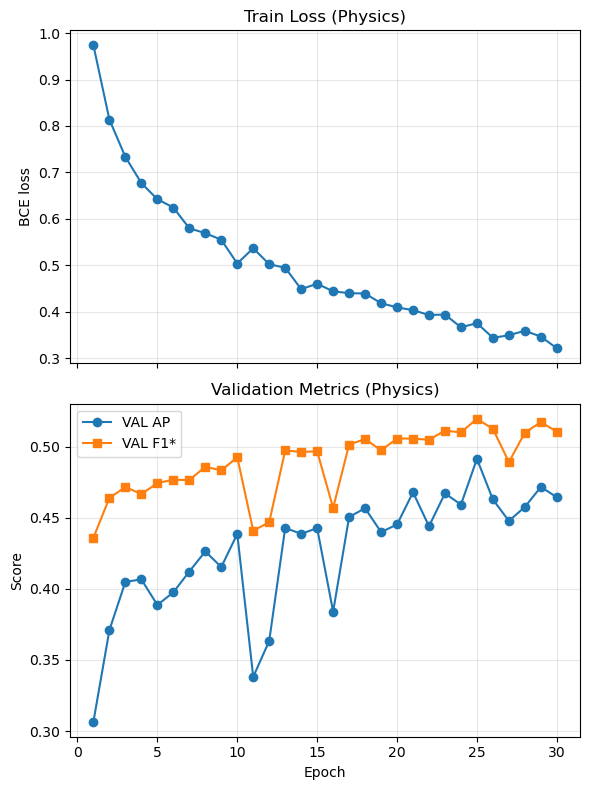

In [5]:
if not train_loss_hist:
    print("Training history empty — rerun the training cell to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (Physics)")
    axes[0].set_ylabel("BCE loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    axes[1].set_title("Validation Metrics (Physics)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()


In [6]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")



[Physics] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         26.673 s
  Epoch time stdev             0.732 s
  Training throughput          44.989 tiles/s
  Peak GPU memory              —
  Inference latency (1 tile)   11.261 ms


In [7]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


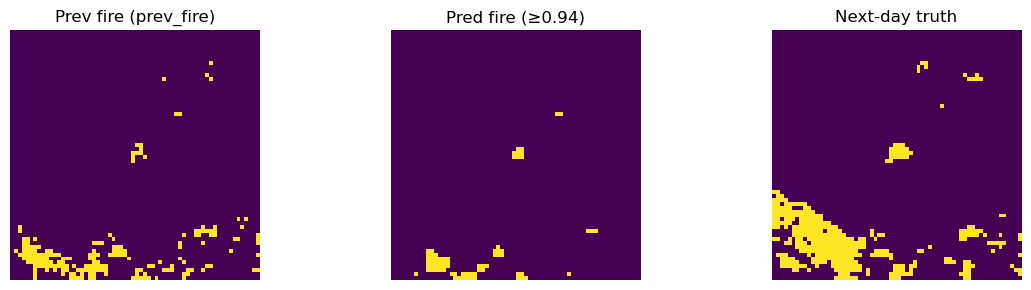

In [8]:
# =========================================================
# Quick qualitative visualization for PhysicsPrior UNet
# =========================================================
@torch.no_grad()
def show_one_physics(ds, model_obj=None, i=0, thr=None):
    if model_obj is None:
        model_obj = physics_model
    if thr is None:
        thr = best_thr_val
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0
    batch = ds[i]
    X_raw0 = batch["X_raw"].unsqueeze(0).to(device)
    y = batch["y"][0].numpy()
    feats = feature_builder(X_raw0)
    prob = torch.sigmoid(model_obj(feats))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(thr)).astype(np.float32)
    prev_img = batch["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1)
    axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1)
    axs[1].set_title(f"Pred fire (≥{thr:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1)
    axs[2].set_title("Next-day truth")
    for a in axs:
        a.axis('off')
    plt.tight_layout()

# Example
show_one_physics(test_ds, i=0)


In [9]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")


Saved model → /Users/queclay/wildfire_artifacts/physics_unet/physics_unet.pt


In [10]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}

def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone

ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f}"
    )


VAL Raw:   0%|          | 0/19 [00:00<?, ?it/s]

TEST Raw:   0%|          | 0/19 [00:00<?, ?it/s]

VAL EMA:   0%|          | 0/19 [00:00<?, ?it/s]

TEST EMA:   0%|          | 0/19 [00:00<?, ?it/s]

VAL Polyak:   0%|          | 0/19 [00:00<?, ?it/s]

TEST Polyak:   0%|          | 0/19 [00:00<?, ?it/s]

Final metrics (val/test):
  Raw    | VAL AP 0.4915 F1 0.5197 thr≈0.906 | TEST AP 0.4356 F1 0.4859
  EMA    | VAL AP 0.4078 F1 0.4711 thr≈0.643 | TEST AP 0.3832 F1 0.4586
  Polyak | VAL AP 0.4627 F1 0.5055 thr≈0.921 | TEST AP 0.4287 F1 0.4843


Using Raw weights for confusion/PR with thr≈0.906
VAL @thr: {'tp': 23016, 'fp': 28245, 'tn': 1163250, 'fn': 14289, 'precision': 0.44899631298639336, 'recall': 0.6169682348209042, 'f1': 0.5197479796779279}
TEST @thr: {'tp': 23202, 'fp': 33487, 'tn': 1156483, 'fn': 15628, 'precision': 0.4092857520858704, 'recall': 0.5975276847796556, 'f1': 0.4858091012164135}
VAL @thr: {'tp': 23016, 'fp': 28245, 'tn': 1163250, 'fn': 14289, 'precision': 0.44899631298639336, 'recall': 0.6169682348209042, 'f1': 0.5197479796779279}
TEST @thr: {'tp': 23202, 'fp': 33487, 'tn': 1156483, 'fn': 15628, 'precision': 0.4092857520858704, 'recall': 0.5975276847796556, 'f1': 0.4858091012164135}


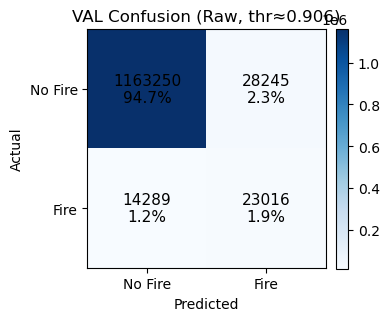

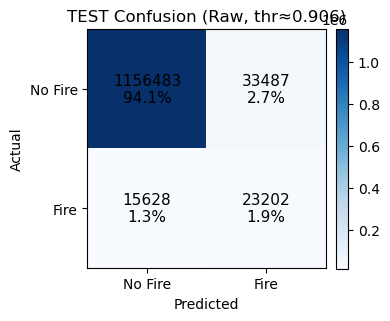

In [11]:
import numpy as np

best_name, best_stats = max(final_metrics.items(), key=lambda kv: kv[1]["val_ap"])
best_model = variants[best_name]
best_thr = best_stats["val_thr"]
print(f"Using {best_name} weights for confusion/PR with thr≈{best_thr:.3f}")

@torch.no_grad()
def confusion_at_thr(model_obj, loader, thr):
    model_obj.eval()
    tp = fp = tn = fn = 0
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy().astype(np.uint8)
        p = np.nan_to_num(p, nan=0.0)
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1))

def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)

def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()

val_stats = confusion_at_thr(best_model, val_loader, best_thr)
test_stats = confusion_at_thr(best_model, test_loader, best_thr)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), f"VAL Confusion ({best_name}, thr≈{best_thr:.3f})")
_plot_confusion(_conf_matrix_from_counts(test_stats), f"TEST Confusion ({best_name}, thr≈{best_thr:.3f})")


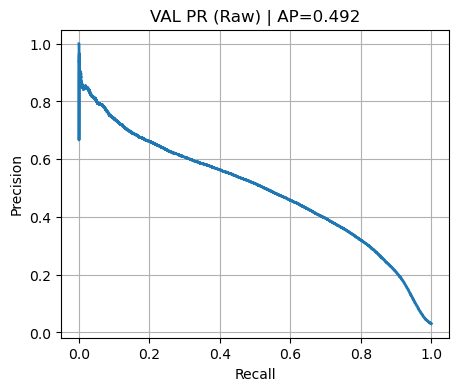

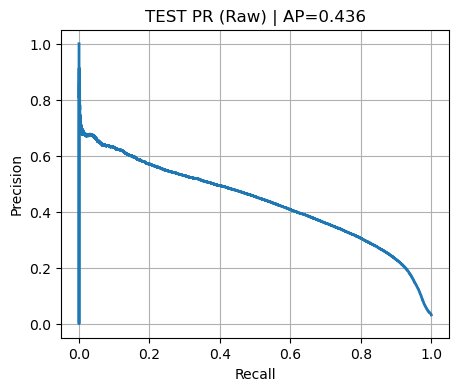

In [12]:
@torch.no_grad()
def pr_curve(model_obj, loader, title="PR Curve"):
    model_obj.eval()
    ps, ts = [], []
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        p = torch.sigmoid(model_obj(feats)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p)
        ts.append(t)
    p = np.concatenate(ps)
    t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True)
    plt.show()

pr_curve(best_model, val_loader, f"VAL PR ({best_name})")
pr_curve(best_model, test_loader, f"TEST PR ({best_name})")


TEST Raw:   0%|          | 0/19 [00:00<?, ?it/s]

TEST metrics: {'ap': 0.4356096887197536, 'best_f1': 0.48590931381667524, 'best_thr': 0.904902458190918, 'chosen_thr': 0.905586302280426}
Confusion counts: {'TP': 23202.0, 'FP': 33487.0, 'FN': 15628.0}
Confusion matrix:
 [[1156483   33487]
 [  15628   23202]]


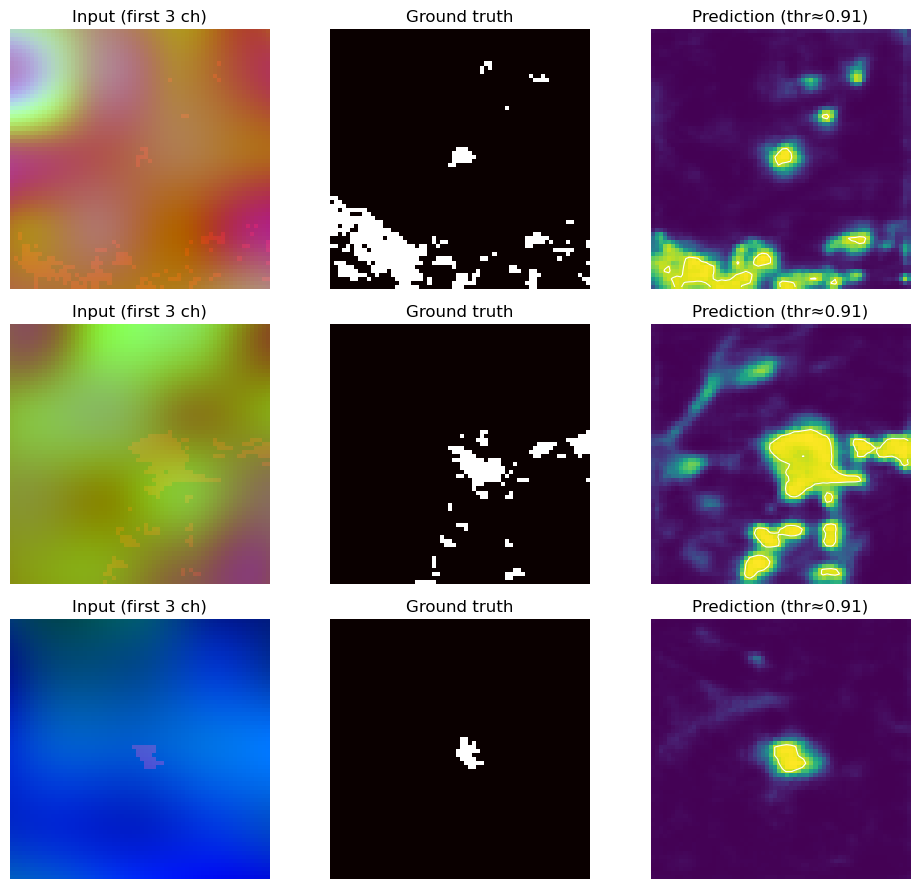

In [17]:
# =========================================================
# Test-set evaluation + qualitative checks
# =========================================================
@torch.no_grad()
def run_test(model_obj, loader, threshold=None, desc="TEST eval"):
    model_obj.eval()
    probs_all, targets_all = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        probs_all.append(torch.sigmoid(logits).detach().cpu())
        targets_all.append(y.detach().cpu())
    probs = torch.cat(probs_all, dim=0)
    targets = torch.cat(targets_all, dim=0)
    p_flat = probs.flatten().numpy()
    t_flat = targets.flatten().numpy()
    ap = average_precision_score(t_flat, p_flat)
    prec, rec, thr = precision_recall_curve(t_flat, p_flat)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr_curve = thr[best_idx] if best_idx < len(thr) else 0.5
    chosen_thr = float(threshold if threshold is not None else best_thr_curve)
    binary = (probs >= chosen_thr).float()
    tp = float((binary * targets).sum().item())
    fp = float((binary * (1 - targets)).sum().item())
    fn = float((((1 - binary) * targets)).sum().item())
    metrics = {
        "ap": float(ap),
        "best_f1": float(f1.max()),
        "best_thr": float(best_thr_curve),
        "chosen_thr": chosen_thr,
    }
    confusion_counts = {"TP": tp, "FP": fp, "FN": fn}
    cm = confusion_matrix(t_flat.astype(int), binary.flatten().numpy().astype(int), labels=[0, 1])
    return metrics, confusion_counts, cm


test_metrics, test_confusion, test_cm = run_test(best_model, test_loader, threshold=best_thr, desc=f"TEST {best_name}")
print("TEST metrics:", test_metrics)
print("Confusion counts:", test_confusion)
print("Confusion matrix:\n", test_cm)


@torch.no_grad()
def visualize_predictions(loader, model_obj=None, n=4, threshold=None):
    if model_obj is None:
        model_obj = best_model
    thr = float(threshold if threshold is not None else test_metrics.get("chosen_thr", best_thr))
    loader_iter = iter(loader)
    fig, axes = plt.subplots(n, 3, figsize=(10, 3 * n))
    axes = np.atleast_2d(axes)
    for row in range(n):
        try:
            batch = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            batch = next(loader_iter)
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        prob = torch.sigmoid(logits).detach().cpu()
        x_raw = batch["X_raw"][0].cpu().numpy()
        img = x_raw[:3]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        gt = y[0, 0].cpu().numpy()
        pred = prob[0, 0].numpy()
        axs = axes[row]
        axs[0].imshow(np.moveaxis(img, 0, -1))
        axs[0].set_title("Input (first 3 ch)")
        axs[0].axis("off")
        im1 = axs[1].imshow(gt, cmap="hot")
        axs[1].set_title("Ground truth")
        axs[1].axis("off")
        im2 = axs[2].imshow(pred, cmap="viridis")
        axs[2].contour(pred, levels=[thr], colors="white", linewidths=0.8)
        axs[2].set_title(f"Prediction (thr≈{thr:.2f})")
        axs[2].axis("off")
    plt.tight_layout()


visualize_predictions(test_loader, model_obj=best_model, n=3, threshold=test_metrics.get("chosen_thr", best_thr))


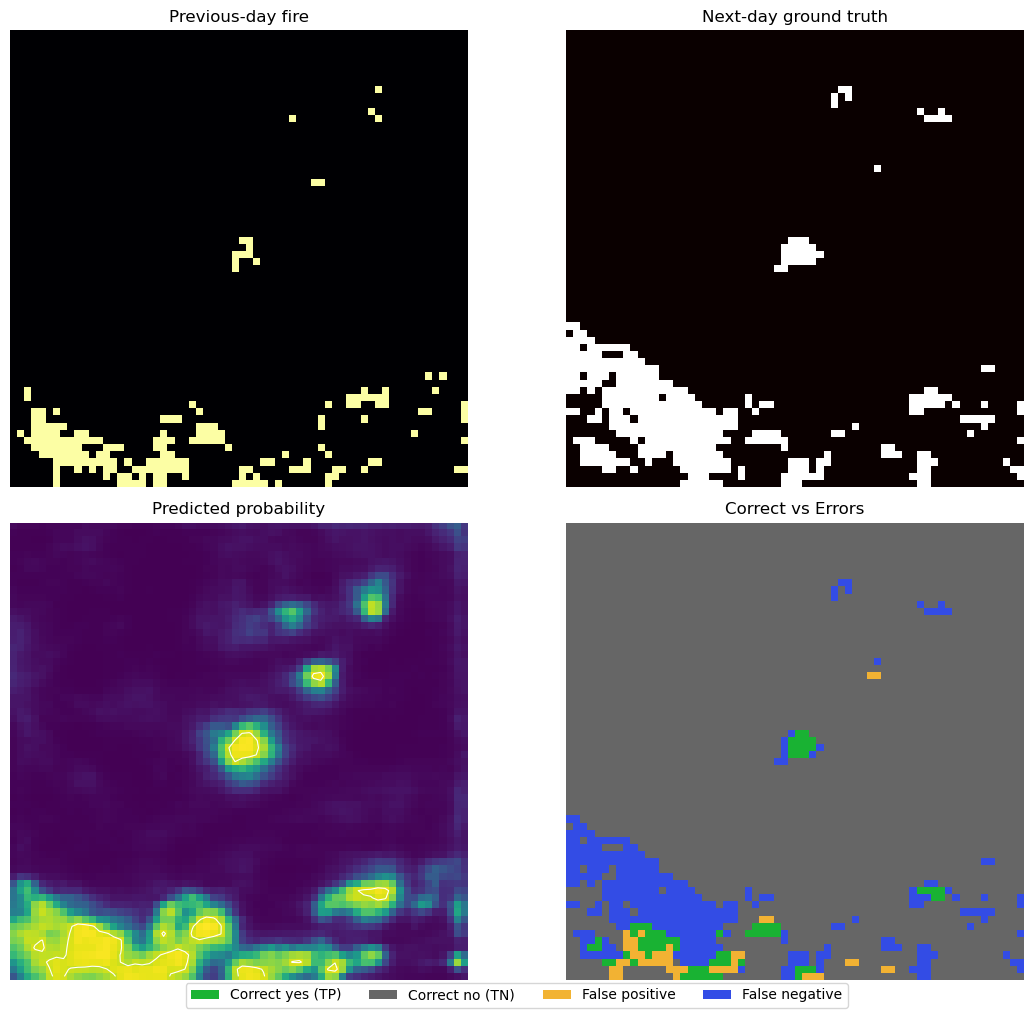

In [19]:
# =========================================================
# Single-tile error-type visualization
# =========================================================
@torch.no_grad()
def plot_error_breakdown(loader, model_obj=None, threshold=None):
    if model_obj is None:
        model_obj = best_model
    thr = float(threshold if threshold is not None else test_metrics.get("chosen_thr", best_thr))
    batch = next(iter(loader))
    feats, y = _forward_batch(model_obj, batch)
    logits = model_obj(feats)
    prob = torch.sigmoid(logits).detach().cpu().numpy()[0, 0]
    pred_mask = (prob >= thr).astype(np.float32)
    gt_mask = y[0, 0].cpu().numpy()
    channel_names = getattr(loader.dataset, "channels", CHANNELS_FOR_MODEL)
    prev_idx = channel_names.index("prev_fire") if "prev_fire" in channel_names else 0
    prev_fire = batch["X_raw"][0, prev_idx].cpu().numpy()
    prev_fire = (prev_fire - prev_fire.min()) / (prev_fire.max() - prev_fire.min() + 1e-6)

    correct_yes = np.logical_and(pred_mask == 1, gt_mask == 1)
    correct_no = np.logical_and(pred_mask == 0, gt_mask == 0)
    false_pos = np.logical_and(pred_mask == 1, gt_mask == 0)
    false_neg = np.logical_and(pred_mask == 0, gt_mask == 1)

    palette = {
        "TP": np.array([0.1, 0.7, 0.2]),
        "TN": np.array([0.4, 0.4, 0.4]),
        "FP": np.array([0.95, 0.7, 0.2]),
        "FN": np.array([0.2, 0.3, 0.9]),
    }
    error_map = np.zeros((*gt_mask.shape, 3), dtype=np.float32)
    error_map[correct_yes] = palette["TP"]
    error_map[correct_no] = palette["TN"]
    error_map[false_pos] = palette["FP"]
    error_map[false_neg] = palette["FN"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0, 0].imshow(prev_fire, cmap="inferno")
    axes[0, 0].set_title("Previous-day fire")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(gt_mask, cmap="hot")
    axes[0, 1].set_title("Next-day ground truth")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(prob, cmap="viridis")
    axes[1, 0].contour(prob, levels=[thr], colors="white", linewidths=0.8)
    axes[1, 0].set_title("Predicted probability")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(error_map)
    axes[1, 1].set_title("Correct vs Errors")
    axes[1, 1].axis("off")

    legend_patches = [
        Patch(facecolor=palette["TP"], edgecolor="none", label="Correct yes (TP)"),
        Patch(facecolor=palette["TN"], edgecolor="none", label="Correct no (TN)"),
        Patch(facecolor=palette["FP"], edgecolor="none", label="False positive"),
        Patch(facecolor=palette["FN"], edgecolor="none", label="False negative"),
    ]
    fig.legend(handles=legend_patches, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.02))
    plt.tight_layout()


plot_error_breakdown(test_loader, model_obj=best_model, threshold=test_metrics.get("chosen_thr", best_thr))
